### Import Libraries and Set Paths

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns

from roc_fns import roc_ovr_all

In [2]:
# Define directories
base_dir = '/Users/jetcalz07/Desktop/MIDS/W281_CV/logo_detection_w281/'
image_dir = base_dir + 'data/images/'
bbox_dir = base_dir + 'data/yolofinalset/obj_train_data/'

### Load Data, Split

In [3]:
df = pd.read_pickle(base_dir+'data/feature_sets/feature_set_v110822.csv')
df = pd.concat([df, df, df, df, df, df, df, df, df], axis=0) # <----- increase size temporarily so each class is represented
print(f"Num Bboxes: {len(df)}")
df.head(2)

Num Bboxes: 14769


,img_file,bbox_file,label,bbox_num,bbox_corners,simple_feature,harris_orb_feature,orb_kp_feature,harris_sift_feature,sift_kp_feature,cm_hsv_0,cm_hsv_2,cm_hsv_3,cm_rgb_0,cm_rgb_2,cm_rgb_3,cm_ycrcb_0,cm_ycrcb_2,cm_ycrcb_3
0,002837.jpg,002837.txt,1.0,1,"[[1, 762, 932, 347, 403], [1, 185, 279, 250, 2...","[[196.0, 193.0, 195.0, 198.0, 198.0, 130.0, 12...","[[134, 69, 30, 175, 13, 66, 54, 40, 172, 132, ...","[[93, 229, 27, 160, 213, 222, 109, 101, 160, 1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 3.0, 5.0, 1.0, 27.0, 17.0, 4.0, 1.0, 11...","[76.49485, 162.83781, 199.68802]","[73.71675845905325, 67.9637041561294, 36.54168...","[57.57648613303671, -76.54733687916887, -39.21...","[198.84003, 121.79107, 73.20924]","[37.08143059480818, 61.253716609134244, 44.857...","[-39.48401557006493, -23.93970058436079, 51.63...","[139.3022, 170.47731, 90.70788]","[44.41095040800821, 24.43668525078755, 28.1218...","[16.23894911389937, -16.547448131172395, -11.1..."
1,002837.jpg,002837.txt,1.0,2,"[[1, 762, 932, 347, 403], [1, 185, 279, 250, 2...","[[152.0, 164.0, 176.0, 172.0, 172.0, 165.0, 12...","[[144, 87, 14, 189, 8, 82, 28, 44, 164, 158, 1...","[[40, 167, 150, 102, 237, 51, 196, 125, 192, 1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 3.0, 106.0, 105.0, 0.0, 0.0, 0.0, ...","[40.56497, 197.80472, 210.7956]","[57.559782849082325, 31.79085828997581, 22.491...","[71.3215894160669, -42.95040131194688, -17.588...","[210.75038, 127.91793, 50.036854]","[22.539858309705632, 58.977960290125125, 28.36...","[-17.60054075561355, -47.06080125467377, 34.17...","[143.80016, 175.76558, 75.07599]","[41.70912118770129, 16.936906444048496, 22.190...","[-32.93018669798095, 10.61953639316704, 16.722..."


In [4]:
# Parse df
feature_cols = ['cm_hsv_0', 'cm_hsv_2', 'cm_hsv_3', 'cm_rgb_0', 'cm_rgb_2', 'cm_rgb_3',
                'cm_ycrcb_0','cm_ycrcb_2', 'cm_ycrcb_3']

# Combine each feature vector into 1-D array
feature_vals = []
for idx, row in df.iterrows():
    vals = []
    for col in feature_cols:
            vals.extend(list(row[col]))
    feature_vals.append(vals)
df['features'] = feature_vals

df.head()


,img_file,bbox_file,label,bbox_num,bbox_corners,simple_feature,harris_orb_feature,orb_kp_feature,harris_sift_feature,sift_kp_feature,cm_hsv_0,cm_hsv_2,cm_hsv_3,cm_rgb_0,cm_rgb_2,cm_rgb_3,cm_ycrcb_0,cm_ycrcb_2,cm_ycrcb_3,features
0,002837.jpg,002837.txt,1.0,1,"[[1, 762, 932, 347, 403], [1, 185, 279, 250, 2...","[[196.0, 193.0, 195.0, 198.0, 198.0, 130.0, 12...","[[134, 69, 30, 175, 13, 66, 54, 40, 172, 132, ...","[[93, 229, 27, 160, 213, 222, 109, 101, 160, 1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 3.0, 5.0, 1.0, 27.0, 17.0, 4.0, 1.0, 11...","[76.49485, 162.83781, 199.68802]","[73.71675845905325, 67.9637041561294, 36.54168...","[57.57648613303671, -76.54733687916887, -39.21...","[198.84003, 121.79107, 73.20924]","[37.08143059480818, 61.253716609134244, 44.857...","[-39.48401557006493, -23.93970058436079, 51.63...","[139.3022, 170.47731, 90.70788]","[44.41095040800821, 24.43668525078755, 28.1218...","[16.23894911389937, -16.547448131172395, -11.1...","[76.49485, 162.83781, 199.68802, 73.7167584590..."
1,002837.jpg,002837.txt,1.0,2,"[[1, 762, 932, 347, 403], [1, 185, 279, 250, 2...","[[152.0, 164.0, 176.0, 172.0, 172.0, 165.0, 12...","[[144, 87, 14, 189, 8, 82, 28, 44, 164, 158, 1...","[[40, 167, 150, 102, 237, 51, 196, 125, 192, 1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 3.0, 106.0, 105.0, 0.0, 0.0, 0.0, ...","[40.56497, 197.80472, 210.7956]","[57.559782849082325, 31.79085828997581, 22.491...","[71.3215894160669, -42.95040131194688, -17.588...","[210.75038, 127.91793, 50.036854]","[22.539858309705632, 58.977960290125125, 28.36...","[-17.60054075561355, -47.06080125467377, 34.17...","[143.80016, 175.76558, 75.07599]","[41.70912118770129, 16.936906444048496, 22.190...","[-32.93018669798095, 10.61953639316704, 16.722...","[40.56497, 197.80472, 210.7956, 57.55978284908..."
2,002837.jpg,002837.txt,1.0,3,"[[1, 762, 932, 347, 403], [1, 185, 279, 250, 2...","[[173.0, 175.0, 179.0, 181.0, 180.0, 177.0, 16...","[[148, 18, 62, 161, 162, 90, 146, 0, 44, 173, ...","[[97, 41, 121, 68, 100, 217, 101, 39, 105, 64,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 8.0, 82.0, 129.0, 1.0, 0.0, 1.0, 3...","[74.71514, 185.4809, 187.13329]","[75.35372550845354, 14.159383823225301, 33.018...","[62.24148576695548, 12.54813329495731, -12.359...","[187.13329, 112.9801, 57.11966]","[33.01873372893843, 59.98636333986114, 13.5509...","[-12.359833569820141, -23.849289930128954, -10...","[128.76869, 169.66412, 87.51522]","[44.67886867883496, 8.721935190194534, 27.7669...","[-16.772304345523, 4.030293608057289, 10.95970...","[74.71514, 185.4809, 187.13329, 75.35372550845..."
3,002837.jpg,002837.txt,1.0,4,"[[1, 762, 932, 347, 403], [1, 185, 279, 250, 2...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[221, 201, 194, 100, 98, 224, 82, 83, 51, 212...",None,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",None,"[13.805555, 164.52083, 214.80556]","[5.6288909724959995, 11.316144287159105, 14.71...","[-2.758756208887799, 7.932613003426183, -12.59...","[214.80556, 141.17361, 76.791664]","[14.713126120811868, 32.85222169493596, 13.805...","[-12.595696747937655, -19.500441157819047, -9....","[155.82639, 170.07639, 83.395836]","[23.92590700159091, 9.20679086712624, 10.32743...","[-17.145156899783824, -1.5324069146049777, 1.8...","[13.805555, 164.52083, 214.80556, 5.6288909724..."
4,002836.jpg,002836.txt,1.0,1,"[[1, 751, 773, 304, 310], [1, 827, 849, 297, 3...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[40, 10, 135, 68, 193, 150, 130, 48, 144, 172...",None,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",None,"[83.51515, 26.060606, 165.59091]","[33.98584483604119, 16.03866402761779, 55.5224...","[-29.66964127611604, 16.138206485285544, -44.6...","[155.7197, 160.34091, 160.35606]","[50.60816714450697, 51.48813184012101, 62.4849...","[-40.12239568816436, -41.86260314284869, -51.3...","[158.98485, 125.69697, 128.72728]","[52.41833256231456, 2.27282828058429, 6.207389...","[-42.3

In [5]:
# Isolate the Color Moment Features
cm_Y = df[['img_file', 'bbox_num', 'label']].copy()

# Split (temp until split directories determined)
X_train, X_test, y_train, y_test = train_test_split(feature_vals, cm_Y, test_size=0.3, random_state=42, stratify=cm_Y['label'], shuffle=True)
y_test.reset_index(level=0, inplace=True)

# Save labels as vector
labels = y_test['label']

In [6]:
# Map in label brand names
class_map= { 0 : 'adidas', 1 : 'dhl', 2 : 'apple', 3 : 'bmw', 4 : 'cocacola', 5 : 'fedex', 6 : 'heineken', 7 : 'pepsi', 8 : 'starbucks', 9 : 'ups'}
y_test['label_name'] = y_test["label"].replace(class_map)
y_test.sort_values('label', ascending=True, inplace=True)
class_names = y_test['label_name'].unique()
print(class_names)

['dhl' 'apple' 'cocacola' 'fedex' 'heineken' 'pepsi' 'starbucks' 'ups']


In [7]:
class_map.values()


dict_values(['adidas', 'dhl', 'apple', 'bmw', 'cocacola', 'fedex', 'heineken', 'pepsi', 'starbucks', 'ups'])

# **Modeling**

## Model 1: K Nearest-Neighbors

### Fit

In [8]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train['label'].values)

KNeighborsClassifier()

### Evaluate Test Set

In [9]:
# Generate preds
preds = neigh.predict(X_test)
y_proba = neigh.predict_proba(X_test)
y_test['pred'] = preds
y_test['pred_name'] = y_test["pred"].replace(class_map)

In [10]:
# Classification Report
print(classification_report(labels, preds, target_names=class_names))
#y_test.groupby(['label_name'])['index'].count() #<--- check counts

              precision    recall  f1-score   support

         dhl       1.00      0.98      0.99       780
       apple       1.00      1.00      1.00         3
    cocacola       1.00      1.00      1.00       130
       fedex       0.99      0.98      0.99       921
    heineken       0.97      0.99      0.98       521
       pepsi       0.98      0.99      0.98       964
   starbucks       0.99      1.00      0.99       553
         ups       0.98      0.99      0.98       559

    accuracy                           0.99      4431
   macro avg       0.99      0.99      0.99      4431
weighted avg       0.99      0.99      0.99      4431



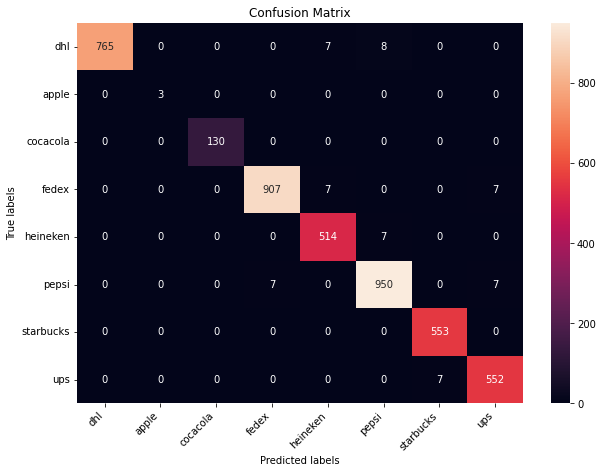

In [11]:
# Confusion Matrix
cm = confusion_matrix(labels, preds)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix')
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names, rotation=0, ha='right')
plt.show()

In [12]:
# # ROC Curves: One vs Rest for each class <--- currently errors bc not all classes in each set, try later w final df
# roc_ovr_all(y_test, y_proba, class_map, figsize=(40, 8))

## Model 2: SVM

### Fit

In [13]:
# Instantiate linear SVC
lsvc = LinearSVC(penalty='l2', dual=False, multi_class = 'ovr', max_iter = 5000, C = 0.22, class_weight='balanced')

# Fit the training histograms and predict with SVC on training data itself
lsvc.fit(X_train, y_train['label'].values)

y_train_score = lsvc.score(X_train, y_train['label'].values)
print("SVC best score on Train set: {:.4f}".format(y_train_score))

SVC best score on Train set: 0.2925


### Evaluate

In [14]:
# Generate preds
lsvc_preds = lsvc.predict(X_test)
y_test['lsvc_pred'] = lsvc_preds
y_test['lsvc_pred_name'] = y_test["lsvc_pred"].replace(class_map)

In [15]:
# Classification Report
print(classification_report(labels, lsvc_preds, target_names=class_names))

              precision    recall  f1-score   support

         dhl       0.31      0.36      0.34       780
       apple       1.00      1.00      1.00         3
    cocacola       0.08      0.43      0.14       130
       fedex       0.36      0.25      0.30       921
    heineken       0.31      0.40      0.35       521
       pepsi       0.30      0.19      0.23       964
   starbucks       0.19      0.10      0.13       553
         ups       0.28      0.32      0.30       559

    accuracy                           0.27      4431
   macro avg       0.35      0.38      0.35      4431
weighted avg       0.29      0.27      0.27      4431



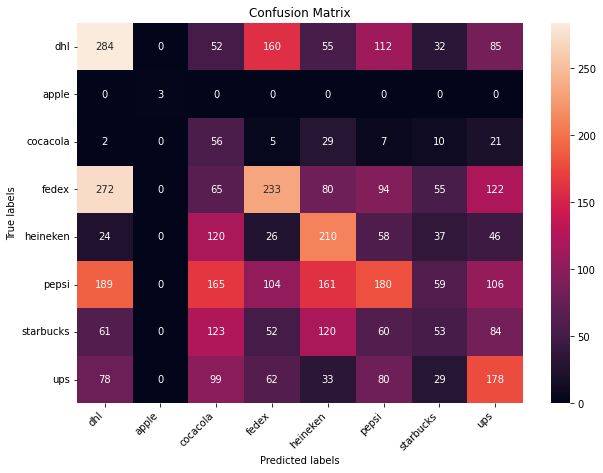

In [16]:
# Confusion Matrix
cm = confusion_matrix(labels, lsvc_preds)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix')
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names, rotation=0, ha='right')
plt.show()

In [17]:
# Can't do ROC bc no probabilities,right?

## Model 3: Log Regression

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

### Fit

In [23]:
# define the multinomial logistic regression model
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# # define the model evaluation procedure
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
# n_scores = cross_val_score(logreg, X_train, y_train['label'].values, scoring='accuracy', cv=cv, n_jobs=-1)
# # report the model performance
# print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

logreg.fit(X_train, y_train['label'].values)

/Users/jetcalz07/opt/miniconda3/envs/w281/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [20]:
# # Instantiate logistic regression models
# logovr = OneVsRestClassifier(LogisticRegression(max_iter=1000))
# # Fit the training histograms and predict with Logistic regression on training data itself 
# logovr.fit(X_train, y_train['label'].values)
# lr_y_train_pred = logovr.predict(X_train)
# print('LR Classifier best score on Train set: {:.4f}'.format(accuracy_score(y_train['label'].values, lr_y_train_pred)))

### Evaluate Log Reg

In [25]:
# Generate preds
lr_preds = logreg.predict(X_test)
y_test['lr_pred'] = lr_preds
y_test['lr_pred_name'] = y_test["lr_pred"].replace(class_map)

In [26]:
# Classification Report
print(classification_report(labels, lr_preds, target_names=class_names))

              precision    recall  f1-score   support

         dhl       0.27      0.18      0.22       780
       apple       0.00      0.00      0.00         3
    cocacola       0.00      0.00      0.00       130
       fedex       0.36      0.39      0.37       921
    heineken       0.34      0.37      0.36       521
       pepsi       0.28      0.52      0.36       964
   starbucks       0.26      0.13      0.17       553
         ups       0.32      0.17      0.23       559

    accuracy                           0.31      4431
   macro avg       0.23      0.22      0.21      4431
weighted avg       0.30      0.31      0.29      4431



/Users/jetcalz07/opt/miniconda3/envs/w281/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jetcalz07/opt/miniconda3/envs/w281/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jetcalz07/opt/miniconda3/envs/w281/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

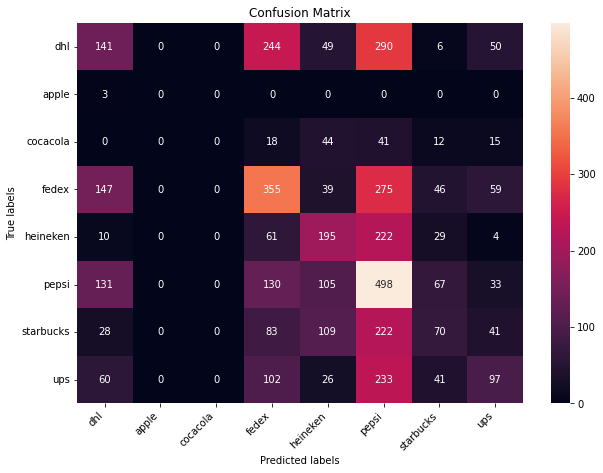

In [27]:
# Confusion Matrix
cm = confusion_matrix(labels, lr_preds)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix')
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names, rotation=0, ha='right')
plt.show()

## DRAFT

### Visualize Errors (waiting to finalize pipeline)

In [ ]:
# # We often misclassify type 5 as type 1, lets find an example
# error_1_5 = y_test.loc[(y_test['label']==5) & (y_test['pred']==1)].copy()
# error_1_5.reset_index(inplace=True)

# err = plt.imread(image_dir + error_1_5.loc[0, 'img_file'])
# plt.imshow(err)

# # To-Do: instead of visualizing image, get the bbox
# # TO-DO: Find an example of the 5 class so we can see the similarities